#### **Imports**

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2


In [2]:
from qumcmc.quantum_mcmc_qulacs_2 import *

In [3]:
import seaborn as sns
sns.set()

#### **Define the Energy Model**

In [4]:
### class to generate BAS dataset of arbitrary gridsize.
from itertools import permutations, product
class bas_dataset:
    def __init__(self, grid_size:int):
        self.grid_size=grid_size
        all_combn=[''.join(p) for p in product('01',repeat=self.grid_size)]
        all_combn.sort(key=lambda s: s.count('1'))
        all_combn.pop(0);all_combn.pop(-1)
        self.__all_combn=all_combn
        self.bas_dict=self.bars_and_stripes_dataset()
        self.dataset=self.bas_dict['stripes']+self.bas_dict['bars']
    
    def vertical_stripes(self):
        vert_stripes=[j*self.grid_size for j in self.__all_combn]
        return vert_stripes

    def horizontal_bars(self):
        hor_bars=[]
        for l in self.__all_combn:
            st=""
            for j in l:
                st=st+j*self.grid_size
            hor_bars.append(st)
        return hor_bars

    def bars_and_stripes_dataset(self):
        bas_dict={'stripes':self.vertical_stripes(),
            'bars':self.horizontal_bars()}
        return bas_dict

    ### create matrix of bitstring: meant for plotting
    def bit_string_to_2d_matrix(self,bitstring, array_shape:int):
        len_bs=len(bitstring)
        list_bs_int=[eval(i) for i in list(bitstring)]
        arr_bs=np.reshape(list_bs_int,(array_shape, array_shape))
        return arr_bs

    ### plot pixels
    def draw_pixelplot(self,bitstring:str,array_shape:int):
        im_array=self.bit_string_to_2d_matrix(bitstring,array_shape)
        plt.title(f"pixel plot for bitstring: {bitstring}")
        pixel_plot=plt.imshow(im_array,cmap='Greens',interpolation='nearest')
        plt.colorbar(pixel_plot)
        plt.show()

In [5]:
def hebbing_learning(list_bas_state:list):
    size=len(list_bas_state[0])
    wts=0
    for i in list_bas_state:
        arr=np.array([-1 if elem == "0" else 1 for elem in i])
        array=np.reshape(arr,(size,1));array_t=np.transpose(array)
        wts+=array@array_t
    wts=wts-len(list_bas_state)*np.identity(size)
    return wts

In [6]:
gridsize=3
bas=bas_dataset(grid_size=gridsize)
wt=hebbing_learning(bas.dataset)
# np.shape(wt);wt

In [7]:
bas.bas_dict

{'stripes': ['001001001',
  '010010010',
  '100100100',
  '011011011',
  '101101101',
  '110110110'],
 'bars': ['000000111',
  '000111000',
  '111000000',
  '000111111',
  '111000111',
  '111111000']}

In [8]:
# define the model # seed 4
np.random.seed(4)#(610358)# should always be in the same cell!  ## best seed -> 610358
n_spins = 10

## construct problem Hamiltonian ##
shape_of_J=(n_spins,n_spins)

## defining J matrix (mutual 1-1 interaction)
J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )
J = 0.5 * (J + J.transpose() )
J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

#evaluating J for BAS dataset
#J=-1*wt#np.array([[0,0,0,4],[0,0,4,0],[0,4,0,0],[4,0,0,0]])
# defining h
#h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)
#h=np.zeros(np.shape(J)[0])
# instantiate the model
model = IsingEnergyFunction(J, h, name= 'my_model')
#model=IsingEnergyFunction(J,h,name=f"BAS data of gridsize {np.shape(J)[0]}")

#### **Exact Analysis**

In [9]:
## set current beta
beta = 1.0#1.100209

## run exact sampling over all possible configurations 
exact_sampled_model = Exact_Sampling(model, beta)

In [10]:
# bas.dataset.sort()
# bas.dataset,len(bas.dataset)

     MODEL : my_model |  beta : 1.0
Num Most Probable States : 12
Entropy : 2.839932901889561
---------------------------------------------


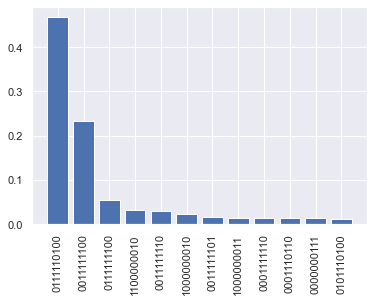

In [11]:
## get the distribution from model
bpd = exact_sampled_model.boltzmann_pd

## exact sampling summary
exact_sampled_model.sampling_summary()

#### **Run Classical MCMC**

In [12]:
steps = 20000
cl_chain =classical_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
)

In [13]:
cl_statistic = get_trajectory_statistics(cl_chain, exact_sampled_model, verbose= False)

#### **Run Quantum Enhaned MCMC**

In [14]:
from qulacsvis import circuit_drawer
import matplotlib.pyplot as plt

In [15]:
steps = 20000
qamcmc_chain_1 =quantum_enhanced_mcmc_2(
    n_hops=steps,
    model=model,
    temperature=1/beta,
    verbose=False
)

In [16]:
steps =20000
qamcmc_chain_2 =quantum_enhanced_mcmc_2(
    n_hops=steps,
    model=model,
    temperature=1/beta,
    verbose=False,
    gamma_range=(0.75,0.9)
)

In [17]:
steps =20000
qamcmc_chain_3 =quantum_enhanced_mcmc(
    n_hops=steps,
    model=model,
    temperature=1/beta,
    verbose=True
)

runnning quantum MCMC steps . ..:   0%|          | 4/20000 [00:00<08:42, 38.25it/s]

starting with:  0101100011 with energy: 0.7990000000000003


runnning quantum MCMC steps . ..: 100%|██████████| 20000/20000 [08:05<00:00, 41.23it/s]


In [18]:
qumcm1_statistic = get_trajectory_statistics(qamcmc_chain_1, exact_sampled_model, verbose= False)
qumcm2_statistic = get_trajectory_statistics(qamcmc_chain_2, exact_sampled_model, verbose= False)
qumcm3_statistic = get_trajectory_statistics(qamcmc_chain_3, exact_sampled_model, verbose= False)

#### **Sampled Distributions**

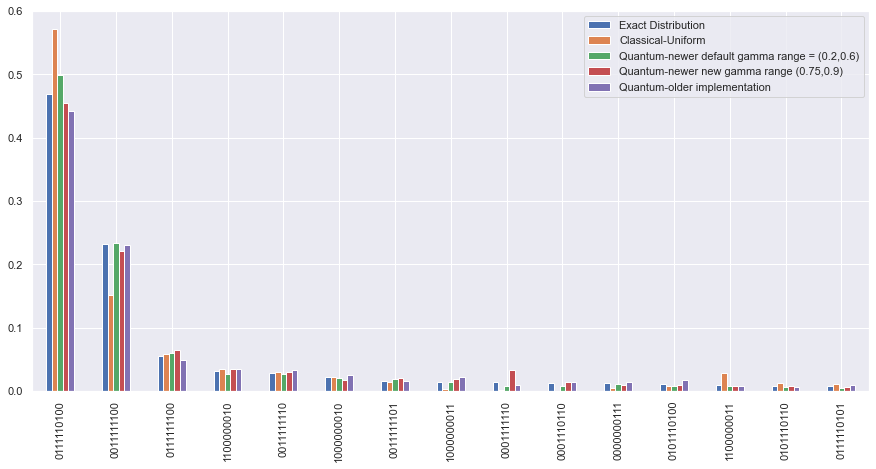

In [19]:
distributions_to_plot = [exact_sampled_model.boltzmann_pd, cl_chain.get_accepted_dict(normalize= True), 
                        qamcmc_chain_1.get_accepted_dict(normalize= True),qamcmc_chain_2.get_accepted_dict(normalize= True)
                            ,qamcmc_chain_3.get_accepted_dict(normalize= True)]
plot_multiple_bargraphs(distributions_to_plot, ['Exact Distribution', 'Classical-Uniform', 'Quantum-newer default gamma range = (0.2,0.6)',
                                                'Quantum-newer new gamma range (0.75,0.9)',
                                                'Quantum-older implementation'], 
                                                list_normalise= [False, False, False,False,False], 
                                                plot_first_few=15)

#### **Proposition Strategy Analysis**

Here we analyse the main adavnatge of the Quantum Enhanced MCMC routine, which is to propose transitions which are are more likely to be accepted when compared to usual classical proposition strategies. In the subsequent plots we compare statistics of all proposed transitions with respect to the *Acceptance-Probabilities* , *Energy-Difference*, and the *Hamming-Distance*.

**Acceptance-Probabilities**


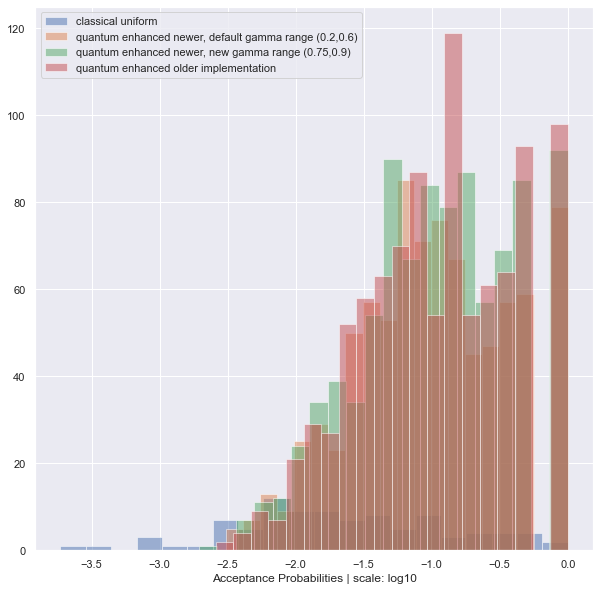

In [27]:
plt.figure(figsize=(10,10))

plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.5, bins= 20)
plt.hist(np.log10(qumcm1_statistic['acceptance_prob']),label= 'quantum enhanced newer, default gamma range (0.2,0.6)' , alpha= 0.5, bins= 20)
plt.hist(np.log10(qumcm2_statistic['acceptance_prob']),label= 'quantum enhanced newer, new gamma range (0.75,0.9)' , alpha= 0.5, bins= 20)
plt.hist(np.log10(qumcm3_statistic['acceptance_prob']),label= 'quantum enhanced older implementation' , alpha= 0.5, bins= 20)


# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

The plot depicts that the *Acceptance-Probability* for the *quantum-enhanced* sampling is skewed towards unity, whereas for the *classical-uniform* sampling it is barely close to unity for most of th cases leading to a large rejection rate of the proposed moves.

**Energy-Difference**

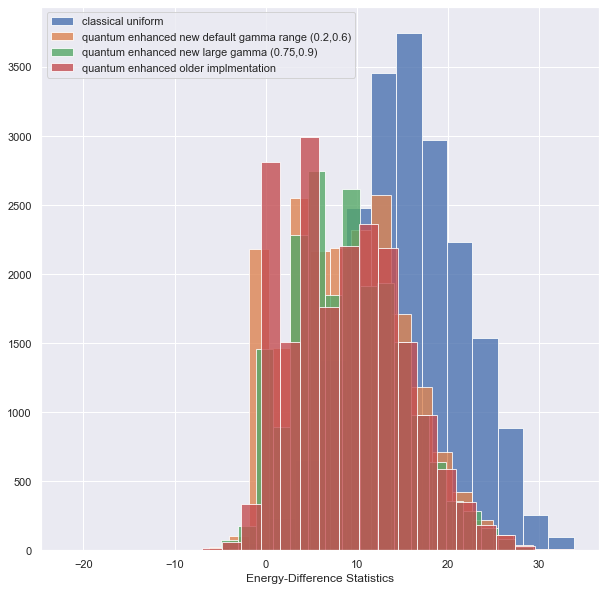

In [21]:
plt.figure(figsize=(10,10))

plt.hist(cl_statistic['energy'],label= 'classical uniform' ,alpha= 0.8, bins= 20)
plt.hist(qumcm1_statistic['energy'],label= 'quantum enhanced new default gamma range (0.2,0.6)' , alpha= 0.8, bins= 20)
plt.hist(qumcm2_statistic['energy'],label= 'quantum enhanced new large gamma (0.75,0.9)' , alpha= 0.8, bins= 20)
plt.hist(qumcm3_statistic['energy'],label= 'quantum enhanced older implmentation' , alpha= 0.8, bins= 20)

# plt.xscale("log")

plt.xlabel("Energy-Difference Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

The plot shows that the *Energy-Difference* of the propose transitions is low for the case of *quantum-enhanced* transitions compared to the *classical-uniform* sampling, this also explains the trend in *Acceptance-Probability* as it is directly dependent on the former.


**Hamming-Distance**

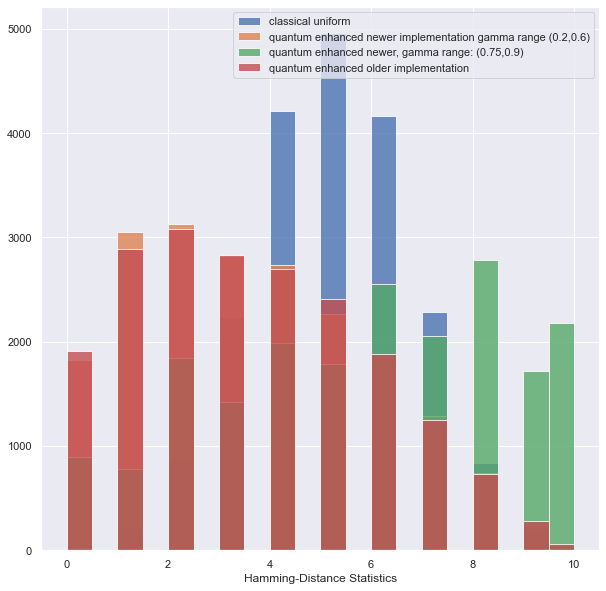

In [22]:
plt.figure(figsize=(10,10))

plt.hist(cl_statistic['hamming'],label= 'classical uniform' ,alpha= 0.8, bins= 20)
plt.hist(qumcm1_statistic['hamming'],label= 'quantum enhanced newer implementation gamma range (0.2,0.6)' , alpha= 0.8, bins= 20)
plt.hist(qumcm2_statistic['hamming'],label= 'quantum enhanced newer, gamma range: (0.75,0.9)' , alpha= 0.8, bins= 20)
plt.hist(qumcm3_statistic['hamming'],label= 'quantum enhanced older implementation' , alpha= 0.8, bins= 20)

# plt.xscale("log")

plt.xlabel("Hamming-Distance Statistics")
# plt.ylabel("Hamming Distance")
plt.legend()
plt.show()

#### **Convergence Analysis**

##### Magnetisation

In [23]:
magnetization_model = exact_sampled_model.get_observable_expectation(magnetization_of_state)
magnetization_c = calculate_runnning_magnetisation(cl_chain)
magnetization_q1 = calculate_runnning_magnetisation(qamcmc_chain_1)
magnetization_q2 = calculate_runnning_magnetisation(qamcmc_chain_2)
magnetization_q3 = calculate_runnning_magnetisation(qamcmc_chain_3)

100%|██████████| 20000/20000 [00:41<00:00, 478.75it/s]


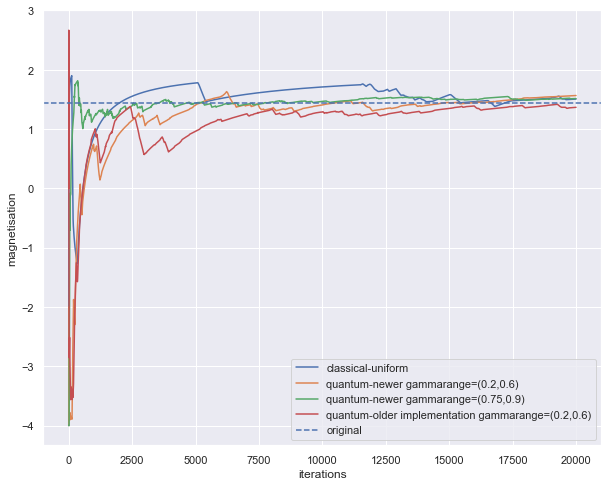

In [24]:
plt.figure(figsize=(10,8))
plt.plot(magnetization_c, label= 'classical-uniform')
plt.plot(magnetization_q1, label= 'quantum-newer gammarange=(0.2,0.6)')
plt.plot(magnetization_q2, label= 'quantum-newer gammarange=(0.75,0.9)')
plt.plot(magnetization_q3, label= 'quantum-older implementation gammarange=(0.2,0.6)')
plt.axhline(magnetization_model, label= 'original',linestyle='--')
plt.xlabel("iterations")
plt.ylabel("magnetisation")
plt.legend()
plt.show()

##### KL Divergence

In [25]:
kldiv_c = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, cl_chain)
kldiv_q1 = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain_1)
kldiv_q2 = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain_2)
kldiv_q3 = calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, qamcmc_chain_3)

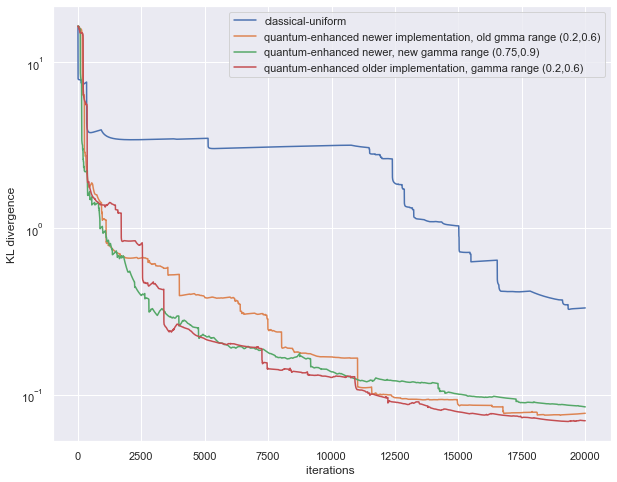

In [26]:
plt.figure(figsize=(10,8))
plt.plot(kldiv_c, label= 'classical-uniform')
plt.plot(kldiv_q1, label= 'quantum-enhanced newer implementation, old gmma range (0.2,0.6)')
plt.plot(kldiv_q2, label= 'quantum-enhanced newer, new gamma range (0.75,0.9)')
plt.plot(kldiv_q3, label= 'quantum-enhanced older implementation, gamma range (0.2,0.6)')
plt.xlabel("iterations ")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()

### discuss the following with Rajarsi

In [27]:
# from qulacs import Observable, PauliOperator

In [28]:
# #
# def hamiltonian_for_mcmc_problem_half(model:IsingEnergyFunction,alpha,gamma):
#     J=model.get_J; h=model.get_h; num_spins=model.num_spins
#     hamiltonian_mcmc= Observable(num_spins)
#     one_minus_gamma_times_alpha=(1-gamma)*alpha#one_minus_gamma_times_alpha
#     for i in range(0,num_spins):
#         pstr = 'Z ' + str(i)
#         hamiltonian_mcmc.add_operator(PauliOperator(pstr, coef=  one_minus_gamma_times_alpha*h[i]))

#         for j in range(0, i):
#             pstr = 'Z ' + str(i) + ' ' + 'Z ' + str(j)
#             hamiltonian_mcmc.add_operator(PauliOperator(pstr,
#                                                             coef=one_minus_gamma_times_alpha* J[i,j]))

#     return hamiltonian_mcmc


In [29]:
# def create_X_mixer_hamiltonian_2(hamiltonian_mcmc_in:Observable,num_spins:int,weight_individual_pauli:int,coef:list):
#     num_sumterms=num_spins-weight_individual_pauli+1
#     list_individual_terms=[("X %d "*weight_individual_pauli) % tuple(range(i,i+weight_individual_pauli)) for i in range(0,num_sumterms)]
#     #print("list_individual_terms:")
#     #print(list_individual_terms)
#     for i in range(0,num_sumterms):
#         hamiltonian_mcmc_in.add_operator(coef=coef[i],string=list_individual_terms[i])
#     return hamiltonian_mcmc_in

In [30]:
# check_1=hamiltonian_for_mcmc_problem_half(model=model,alpha=model.alpha,gamma=gamma)
# weight_individual_pauli=1
# num_sumterms=n_spins-weight_individual_pauli+1
# check_2=create_X_mixer_hamiltonian_2(check_1,n_spins,1,coef=[gamma]*num_sumterms)


In [31]:
# check_2.get_matrix().A

#### ...............................................................

In [32]:
# from qulacs import PauliOperator
# Pauli_string='Z 0 I 1'
# pauli_check=PauliOperator(Pauli_string,coef=1)

In [33]:
# pauli_check.get_pauli_id_list()

In [34]:
# from qulacs.gate import merge,Identity,Z

In [35]:
# gate_Z0_I1=merge([Z(2),Identity(1)])

In [36]:
# gate_Z0_I1.get_matrix()

In [37]:
# gate_Z0_I1.get_matrix()

In [38]:
# Z(0).get_matrix(),Z(2).get_matrix()

In [39]:
# # qulacs imports
# from qulacs import QuantumState, QuantumCircuit
# from qulacsvis import circuit_drawer
# from scipy.linalg import expm
# from qulacs.gate import DenseMatrix
# from qulacs.gate import X, Y, Z  , Pauli, Identity, merge

# checking effect of changing gamma and delta_t

In [1]:
## import essential modules 
import qumcmc 
from qumcmc.basic_utils import *
# from qumcmc.energy_models import IsingEnergyFunction
from qumcmc.energy_models import IsingEnergyFunction, Exact_Sampling

from qumcmc.classical_mcmc_routines import classical_mcmc
#from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc     #for Qulacs Simulator backend (** Faster )
from qumcmc.quantum_mcmc_routines_qulacs_exact import quantum_mcmc_exact
#  from qumcmc.quantum_mcmc_routines_qiskit import quantum_enhanced_mcmc   #for qiskit Aer's Simulator backend 

from qumcmc.trajectory_processing import calculate_running_js_divergence, calculate_running_kl_divergence, calculate_runnning_magnetisation, get_trajectory_statistics
from scipy.linalg import expm
from qulacs.gate import DenseMatrix, SparseMatrix
from qulacs import QuantumState
from qumcmc.quantum_mcmc_routines_qulacs import quantum_enhanced_mcmc
from qumcmc.quantum_mcmc_qulacs_2 import quantum_enhanced_mcmc_2

import pickle

In [3]:
### while collecting data
# define the model # seed 4
# seed_val=4
# np.random.seed(seed_val)#(610358)# should always be in the same cell!  ## best seed -> 610358
# n_spins = 10

# ## construct problem Hamiltonian ##
# shape_of_J=(n_spins,n_spins)

# ## defining J matrix (mutual 1-1 interaction)
# J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
# J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )
# J = 0.5 * (J + J.transpose() )
# J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

# #evaluating J for BAS dataset
# #J=-1*wt#np.array([[0,0,0,4],[0,0,4,0],[0,4,0,0],[4,0,0,0]])
# # defining h
# #h = np.round(0.5 * np.random.randn(n_spins), decimals=2)
# h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)
# #h=np.zeros(np.shape(J)[0])
# # instantiate the model
# model = IsingEnergyFunction(J, h, name= 'my_model')
#model=IsingEnergyFunction(J,h,name=f"BAS data of gridsize {np.shape(J)[0]}")

In [2]:
def define_ising_model(n_spins:int,seed_val:int):
    # define the model # seed 4
    np.random.seed(seed_val)#(610358)# should always be in the same cell!  ## best seed -> 610358

    ## construct problem Hamiltonian ##
    shape_of_J=(n_spins,n_spins)

    ## defining J matrix (mutual 1-1 interaction)
    J =  np.round(np.random.choice([+1, 0, -1], size=(n_spins, n_spins)), decimals=2) 
    J =  np.random.uniform(low= -2, high= 2, size= shape_of_J )
    J = 0.5 * (J + J.transpose() )
    J = np.round( J - np.diag(np.diag(J)) , decimals= 3)

    # defining h
    h = np.round(np.random.uniform(low= -1, high = 1, size= (n_spins)), decimals=2)
    # instantiate the model
    model = IsingEnergyFunction(J, h, name= 'my_model')
    return model


### different ranges of gamma

In [ ]:
#for collecting data

# n_spins=11; beta=1.5
# for seed_val in tqdm(range(1,10+1)):
#     model=define_ising_model(n_spins=n_spins,seed_val=seed_val)
#     ## run exact sampling over all possible configurations 
#     exact_sampled_model = Exact_Sampling(model, beta)
#     ## get the distribution from model
#     bpd = exact_sampled_model.boltzmann_pd
#     delta_t=0.8
#     list_range_gamma=[(0.01,0.1),(0.11,0.4),(0.41,0.7),(0.75,0.95)]
#     dict_mcmc_chains_different_gamma_ranges={}
#     for i in range(0,len(list_range_gamma)):
#         steps=10000
#         temp_val=1/beta
#         qamcmc_chain=quantum_enhanced_mcmc_2(n_hops=steps,
#                                                 model=model,
#                                                 temperature=temp_val,
#                                                 verbose= True,
#                                                 delta_time=delta_t,
#                                                 gamma_range=list_range_gamma[i]
#         )
#         dict_mcmc_chains_different_gamma_ranges[f"gamma_range={list_range_gamma[i]}"]=qamcmc_chain
#     # storing the data
#     path=f'''D:\\Desktop\\QBM project with Manuel\\qumcmc_apr\\quMCMC\\gamma_variation\\num_spins_{n_spins}'''
#     name=path+f'_Gamma_var_num_spins_{n_spins}_beta_{beta}_seed_{seed_val}.pkl'
#     with open(name,'wb') as f:
#         pickle.dump(dict_mcmc_chains_different_gamma_ranges,f)

### for plotting

100%|██████████| 10/10 [01:10<00:00,  7.01s/it]


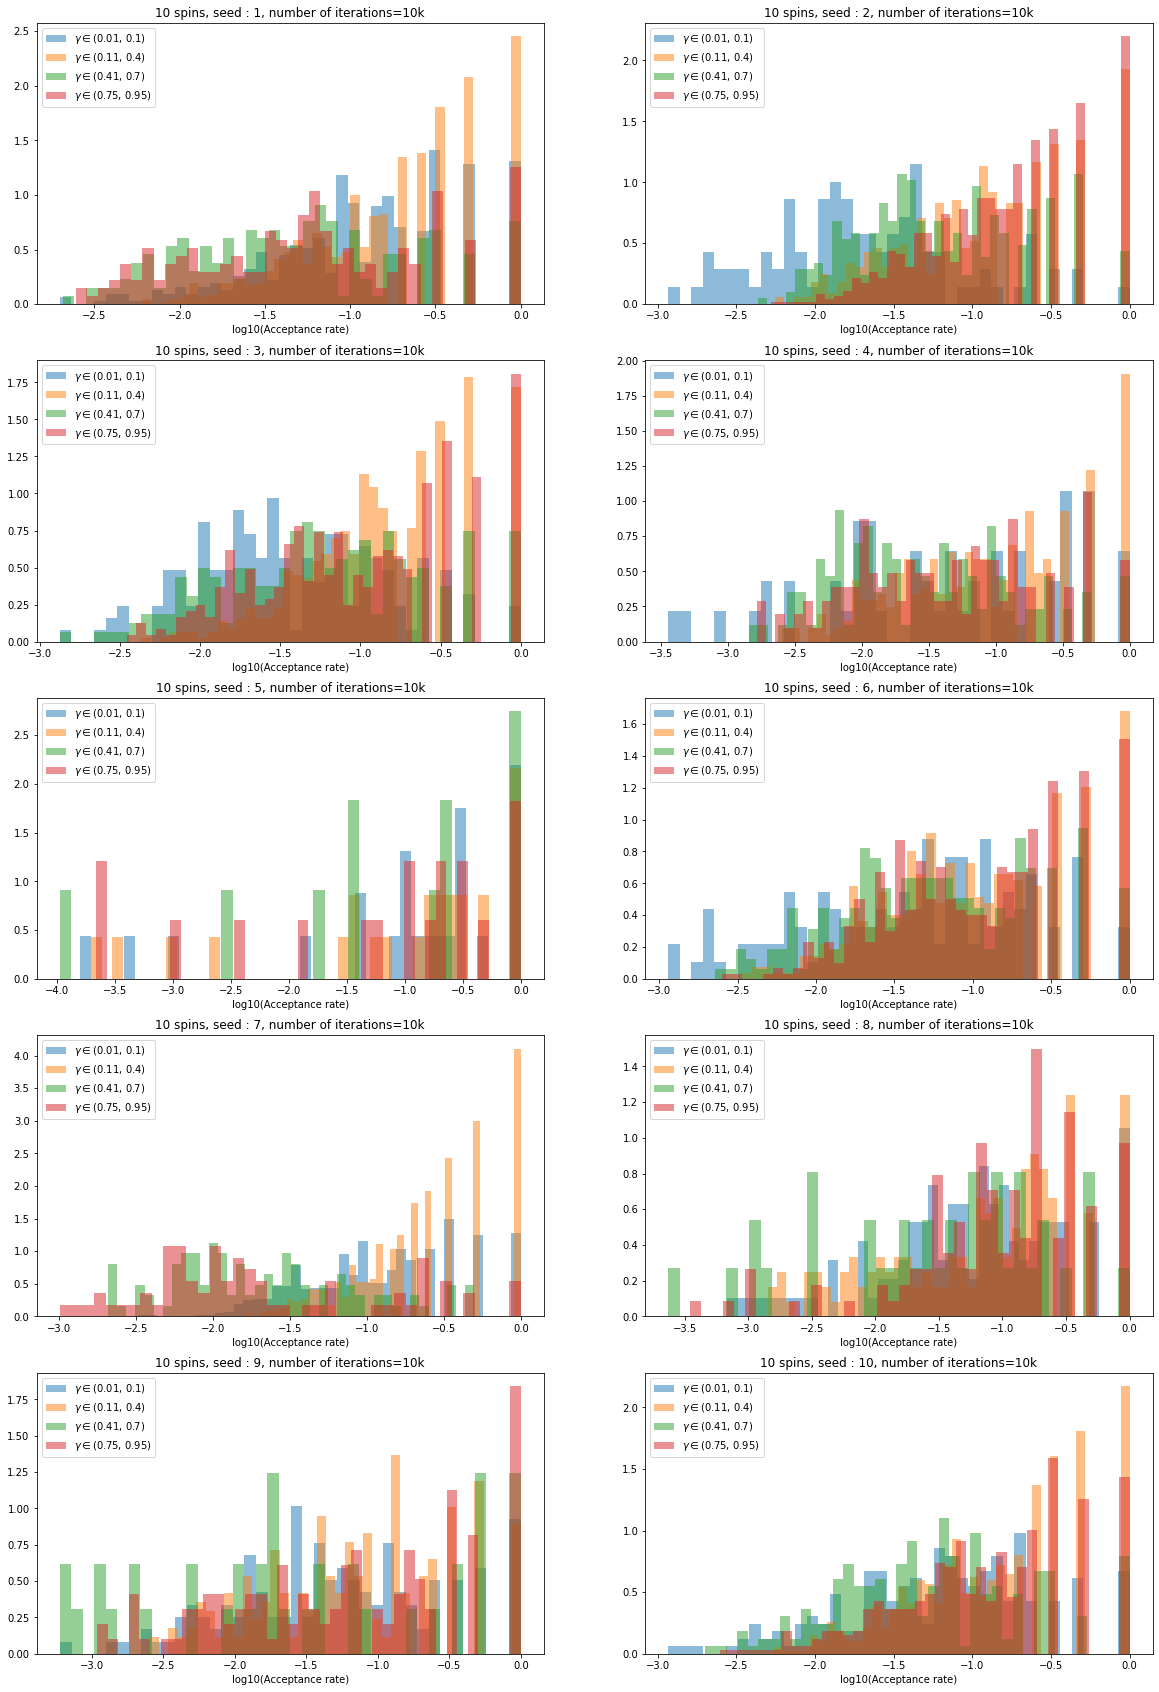

In [50]:
################################## Plots for different gamma ranges
# model for the loaded dataset
dict_acceptance_rate_numspins_10={};gamma_range_name=['pert','low','mid','high']
plt.figure(1,figsize=(20,30))
for seed_val in tqdm(range(1,11)):
    n_spins=10; beta=1.5
    model=define_ising_model(n_spins=n_spins,seed_val=seed_val)
    ## run exact sampling over all possible configurations 
    exact_sampled_model = Exact_Sampling(model, beta)
    ## get the distribution from model
    bpd = exact_sampled_model.boltzmann_pd
    delta_t=0.8
    list_range_gamma=[(0.01,0.1),(0.11,0.4),(0.41,0.7),(0.75,0.95)]

    dict_mcmc_chains_different_gamma_ranges={}
    #name='Gamma_var_gamma_range_[(0.01, 0.1), (0.11, 0.4), (0.41, 0.7), (0.75, 0.95)]_delta_t_0.8_num_spins_10_seed_4_beta_1.5.pkl'
    name=f'D:\\Desktop\\QBM project with Manuel\\qumcmc_apr\\quMCMC\\gamma_variation\\num_spins_{n_spins}_Gamma_var_num_spins_{n_spins}_beta_{beta}_seed_{seed_val}.pkl'
    #name='num_spins_10_Gamma_var_num_spins_10_beta_1.5_seed_1.pkl'# surprisingly not working?
    with open(name,'rb') as f:
        dict_mcmc_chains_different_gamma_ranges=pickle.load(f)

    ###dict mcmc statistics
    dict_mcmc_statistics={}
    for i in range(0,len(list_range_gamma)):
        #print(f"gamma range: {list_range_gamma[i]}")
        mcmc_chain=dict_mcmc_chains_different_gamma_ranges[f"gamma_range={list_range_gamma[i]}"]
        statistics=get_trajectory_statistics(mcmc_chain,exact_sampled_model,verbose=False)
        dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]=statistics
    #
    # ### acceptance probability plot
    #plt.figure(seed_val+1,figsize=(10,10))
    #plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.8, bins= 20)
    plt.subplot(5,2,seed_val)
    for i in range(0, len(list_range_gamma)):
        mcmc_statistics=dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]
        (n,bins,patches)=plt.hist(np.log10(mcmc_statistics["acceptance_prob"]),
            label= r'$\gamma \in$'+str(list_range_gamma[i]), 
            alpha= 0.5, bins= 40,density=True)
        dict_acceptance_rate_numspins_10[f'seedval:{seed_val},gamma_range:{gamma_range_name[i]}']=n
    plt.xlabel("log10(Acceptance rate)")
    plt.title(f"{n_spins} spins, seed : {seed_val}, number of iterations=10k")
    plt.legend()
plt.savefig(f'D:\\Desktop\\QBM project with Manuel\\qumcmc_apr\\quMCMC\\gamma_variation\\Acceptance Probabilities num_spins={n_spins}.pdf')
plt.show()
    #
    #######################
    # plt.figure(seed_val+2,figsize=(10,12))
    # for i in tqdm(range(0,len(list_range_gamma))):
    #     mcmc_statistics=dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]
    #     plt.subplot(2,2,i+1)
    #     plt.hist(np.log10(mcmc_statistics["acceptance_prob"]),
    #         label= r'$\gamma \in$'+str(list_range_gamma[i]), 
    #         alpha= 0.6, bins= 50)
    #     plt.legend()
    # plt.xlabel("Acceptance Probabilities | scale: log10")
    # plt.suptitle(f"Acceptance Probabilities num_spins={n_spins}, number of iterations=10k")

    # plt.savefig(f'D:\\Desktop\\QBM project with Manuel\\qumcmc_apr\\quMCMC\\gamma_variation\\Acceptance Probabilities individual num_spins={n_spins}, seedval={seed_val}_.pdf')
    # plt.show()

    # #
    # ### hamming distance plot
    # plt.figure(seed_val+3,figsize=(8,8))
    # for i in range(0,len(list_range_gamma)):
    #     mcmc_statistics=dict_mcmc_statistics[f'gamma_range={list_range_gamma[i]}']
    #     list_hamming_dist_accepted=[mcmc_statistics['hamming'][k]['accepted']/mcmc_statistics['hamming'][k]['total'] 
    #                                 if mcmc_statistics['hamming'][k]['total']!=0 else 0 for k in range(0,n_spins+1) ]
    #     list_hamming_dist_rejected=[mcmc_statistics['hamming'][k]['rejected']/mcmc_statistics['hamming'][k]['total'] 
    #                                 if mcmc_statistics['hamming'][k]['total']!=0 else 0 for k in range(0,n_spins+1) ]
    #     #list_hamming_dist_total=[mcmc_statistics['hamming'][k]['total'] for k in range(0,n_spins+1)]
    #     plt.subplot(2,2,i+1)
    #     plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_accepted,'b',label=r'$\frac{accepted}{proposed}$')
    #     plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_rejected,'g',markerfmt="X",label=r'$\frac{rejected}{proposed}$')
    #     #plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_total,'k',markerfmt="x",label='no. of proposals')
    #     plt.title(r'$\gamma \in $'+str(list_range_gamma[i]))
    #     plt.yscale('log')
    # plt.legend(bbox_to_anchor=(1.75,1.3),fontsize=20)
    # plt.suptitle(f'Hamming distance plot: num spins={n_spins}, beta={beta}, no. of iterations={10}k')

    # plt.savefig(f'D:\\Desktop\\QBM project with Manuel\\qumcmc_apr\\quMCMC\\gamma_variation\\Hamming_distance={n_spins}, seedval={seed_val}_.pdf')
    # plt.show()

    ### magnetisation value
    #plt.figure(4,figsize=(8,8))
########################################

In [31]:
dict_acceptance_rate_numspins_10
check=np.zeros((40,10))
for i in range(1,11):
    check[:,i-1]=dict_acceptance_rate_numspins_10[f'seedval:{i},gamma_range:low']

In [34]:
print(check[:5,:])

[[0.04341616 0.06122505 0.02261913 0.09780811 0.43154948 0.0365153
  0.04888325 0.16525943 0.11870036 0.05175016]
 [0.         0.         0.         0.09780811 0.         0.07303061
  0.         0.24788915 0.         0.02587508]
 [0.02170808 0.06122505 0.02261913 0.         0.43154948 0.07303061
  0.06517767 0.08262972 0.17805054 0.02587508]
 [0.04341616 0.06122505 0.06785738 0.09780811 0.         0.0365153
  0.08147209 0.         0.11870036 0.02587508]
 [0.08683232 0.18367514 0.06785738 0.19561622 0.         0.0365153
  0.0977665  0.24788915 0.17805054 0.15525049]]


In [24]:
dict_mcmc_chains_different_gamma_ranges={}
#name='Gamma_var_gamma_range_[(0.01, 0.1), (0.11, 0.4), (0.41, 0.7), (0.75, 0.95)]_delta_t_0.8_num_spins_10_seed_4_beta_1.5.pkl'
name=f'D:\\Desktop\\QBM project with Manuel\\qumcmc_apr\\quMCMC\\gamma_variation\\num_spins_10_Gamma_var_num_spins_{n_spins}_beta_{beta}_seed_{seed_val}.pkl'
#name='num_spins_10_Gamma_var_num_spins_10_beta_1.5_seed_1.pkl'# surprisingly not working?
with open(name,'rb') as f:
    dict_mcmc_chains_different_gamma_ranges=pickle.load(f)

In [ ]:
# dict mcmc statistics
dict_mcmc_statistics={}
for i in range(0,len(list_range_gamma)):
    print(f"gamma range: {list_range_gamma[i]}")
    mcmc_chain=dict_mcmc_chains_different_gamma_ranges[f"gamma_range={list_range_gamma[i]}"]
    statistics=get_trajectory_statistics(mcmc_chain,exact_sampled_model,verbose=False)
    dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]=statistics
dict_mcmc_statistics.keys()

In [19]:
# dict_mcmc_statistics['gamma_range=(0.01, 0.1)']['hamming']

confirm things regarding KL and skipping first few values

In [26]:
# dict mcmc statistics
dict_KL={}
for i in range(0,len(list_range_gamma)):
    print(f"gamma range: {list_range_gamma[i]}")
    mcmc_chain=dict_mcmc_chains_different_gamma_ranges[f"gamma_range={list_range_gamma[i]}"]
    dict_KL[f"gamma_range={list_range_gamma[i]}"]=calculate_running_kl_divergence(
            exact_sampled_model.boltzmann_pd,mcmc_chain
        )

gamma range: (0.01, 0.1)
gamma range: (0.11, 0.4)
gamma range: (0.41, 0.7)
gamma range: (0.75, 0.95)


### 1. Acceptance probability plot

In [ ]:
# ### acceptance probability plot
plt.figure(figsize=(10,10))

#plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.8, bins= 20)
for i in tqdm(range(0, len(list_range_gamma))):
    mcmc_statistics=dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]
    plt.hist(np.log10(mcmc_statistics["acceptance_prob"]),
         label= r'$\gamma \in$'+str(list_range_gamma[i]), 
         alpha= 0.4, bins= 50)
# plt.xscale("log")

plt.xlabel("Acceptance Probabilities | scale: log10")
plt.title(f"num_spins={n_spins}, number of iterations=10k")
plt.legend()
plt.show()

plt.figure(2,figsize=(10,12))
for i in tqdm(range(0,len(list_range_gamma))):
    mcmc_statistics=dict_mcmc_statistics[f"gamma_range={list_range_gamma[i]}"]
    plt.subplot(2,2,i+1)
    plt.hist(np.log10(mcmc_statistics["acceptance_prob"]),
         label= r'$\gamma \in$'+str(list_range_gamma[i]), 
         alpha= 0.6, bins= 50)
    plt.legend()

plt.xlabel("Acceptance Probabilities | scale: log10")
plt.suptitle(f"Acceptance Probabilities num_spins={n_spins}, number of iterations=10k")


# plt.ylabel("Hamming Distance")
plt.show()

### 2. Hamming distance plot

In [ ]:
# mcmc_statistics=dict_mcmc_statistics['gamma_range=(0.41, 0.7)']
# list_hamming_dist_accepted=[mcmc_statistics['hamming'][k]['accepted'] for k in range(0,n_spins+1)]
# list_hamming_dist_rejected=[mcmc_statistics['hamming'][k]['rejected'] for k in range(0,n_spins+1)]
# list_hamming_dist_total=[mcmc_statistics['hamming'][k]['total'] for k in range(0,n_spins+1)]

In [ ]:
plt.figure(3,figsize=(8,8))


for i in tqdm(range(0,len(list_range_gamma))):

    mcmc_statistics=dict_mcmc_statistics[f'gamma_range={list_range_gamma[i]}']
    list_hamming_dist_accepted=[mcmc_statistics['hamming'][k]['accepted']/mcmc_statistics['hamming'][k]['total'] 
                                if mcmc_statistics['hamming'][k]['total']!=0 else 0 for k in range(0,n_spins+1) ]
    list_hamming_dist_rejected=[mcmc_statistics['hamming'][k]['rejected']/mcmc_statistics['hamming'][k]['total'] 
                                if mcmc_statistics['hamming'][k]['total']!=0 else 0 for k in range(0,n_spins+1) ]
    #list_hamming_dist_total=[mcmc_statistics['hamming'][k]['total'] for k in range(0,n_spins+1)]


    plt.subplot(2,2,i+1)
    plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_accepted,'b',label=r'$\frac{accepted}{proposed}$')
    plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_rejected,'g',markerfmt="X",label=r'$\frac{rejected}{proposed}$')
    #plt.stem(list(mcmc_statistics['hamming'].keys()),list_hamming_dist_total,'k',markerfmt="x",label='no. of proposals')
    plt.title(r'$\gamma \in $'+str(list_range_gamma[i]))
    plt.yscale('log')
    # ax.set_xlabel("hamming distance")
    # ax.set_ylabel("number of samples")
    # ax.set_title(f"num_spins={n_spins}, number of iterations=10k")
plt.legend(bbox_to_anchor=(1.75,1.3),fontsize=20)
plt.suptitle(f'Hamming distance plot: num spins={n_spins}, beta={beta}, no. of iterations={10}k')

### 3. KL plot

In [105]:
# this function would be useful for plotting curves
def plot_with_error_band(xval:list,y_list_of_list:list,label:str,
                            std_dev_multiplicative_factor:int=1,
                            alpha_for_plot:float=0.5):

    curve_of_mean_value=np.mean(y_list_of_list,axis=0)
    standard_dev_band=np.std(y_list_of_list,axis=0)
    plt.plot(xval,curve_of_mean_value,"-",label=label)
    plt.fill_between(xval,
                        curve_of_mean_value-standard_dev_band* std_dev_multiplicative_factor,
                        curve_of_mean_value+standard_dev_band* std_dev_multiplicative_factor,
                        alpha=alpha_for_plot)

In [ ]:
plt.figure(figsize=(10,8))

for i in range(0,len(list_range_gamma)):
    list_of_list_kl=[dict_KL[f"gamma_range={list_range_gamma[i]}"]
                    ]
    xval=list(range(0,len(list_of_list_kl[0])))
    plot_with_error_band(xval,list_of_list_kl,label=r'$\gamma \in$'+str(list_range_gamma[i]))

plt.xlabel("iterations")
plt.ylabel("KL divergence")
plt.yscale('log')
plt.legend()
plt.show()

### checking effect of different range of delta_t

In [22]:
# for i in tqdm(range(0, len(list_delta_t))):
#     steps=10000
#     qamcmc_chain=quantum_enhanced_mcmc_2(n_hops=steps,
#                                          model=model,
#                                          temperature=1/beta,
#                                          verbose=False,
#                                          delta_time=delta_t)#,
#                                          #initial_state='0010011100')
#     dict_delta_t[i]=qamcmc_chain

100%|██████████| 10/10 [1:19:17<00:00, 475.76s/it]


In [6]:
# name=f'delta_t_{delta_t}_num_spins_{n_spins}_seed_{seed_val}_beta_{beta}.pkl'

In [24]:
# with open(name,'wb') as f:
#     pickle.dump(dict_delta_t,f)

In [ ]:
# ### acceptance probability plot
# plt.figure(figsize=(10,10))

# #plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.8, bins= 20)
# for i in tqdm(range(0, len(list_delta_t))):
#     mcmc_statistics=dict_mcmc_statistics[list_delta_t[i]]
#     plt.hist(np.log10(mcmc_statistics["acceptance_prob"]),
#          label= r'$\delta$ t='+str(list_delta_t[i]), 
#          alpha= 0.6, bins= 50)
# # plt.xscale("log")

# plt.xlabel("Acceptance Probabilities | scale: log10")
# plt.title("num_spins=10, number of iterations=10k")
# # plt.ylabel("Hamming Distance")
# plt.legend()
# plt.show()

In [ ]:
# ###  energy difference
# plt.figure(figsize=(10,10))

# #plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.8, bins= 20)
# for i in tqdm(range(0, len(list_delta_t))):
#     mcmc_statistics=dict_mcmc_statistics[list_delta_t[i]]
#     plt.hist(mcmc_statistics['energy'],
#          label= r'$\delta$ t='+str(i), 
#          alpha= 0.6, bins= 50)
# # plt.xscale("log")

# plt.xlabel("Energy-Difference Statistics")
# plt.title("num_spins=10, number of iterations=10k")
# # plt.ylabel("Hamming Distance")
# plt.legend()
# plt.show()

In [ ]:
# # hamming distance
# plt.figure(figsize=(10,10))

# #plt.hist(np.log10(cl_statistic['acceptance_prob']),label= 'classical uniform' ,alpha= 0.8, bins= 20)
# for i in tqdm(range(0, len(list_delta_t))):
#     mcmc_statistics=dict_mcmc_statistics[list_delta_t[i]]
#     plt.hist(mcmc_statistics['hamming'],
#          label= r'$\delta$ t='+str(i), 
#          alpha= 0.6, bins= 50)
# # plt.xscale("log")

# plt.xlabel("Hamming-distanc-Statistics")
# plt.title("num_spins=10, number of iterations=10k")
# # plt.ylabel("Hamming Distance")
# plt.legend()
# plt.show()

In [ ]:
# dict_magnetisation={}

In [ ]:
# ### magnetisation analysis
# magnetization_model = exact_sampled_model.get_observable_expectation(magnetization_of_state)

# for i in tqdm(range(0, len(list_delta_t))):
#     mcmc_chain=dict_delta_t[list_delta_t[i]]
#     mag_quantum=calculate_runnning_magnetisation(mcmc_chain)
#     dict_magnetisation[list_delta_t[i]]=mag_quantum

In [ ]:
# # running magnetisation
# plt.figure(figsize=(10,8))

# for i in tqdm(range(0, len(list_delta_t))):
#     mag=dict_magnetisation[list_delta_t[i]]
#     plt.plot(mag, label=r'$\delta$ t='+str(list_delta_t[i]))

# plt.axhline(magnetization_model, label= 'original', linestyle='--')
# plt.xlabel("iterations")
# plt.ylabel("magnetisation")
# plt.legend()
# plt.show()

In [ ]:
# ### KL Divergence
# dict_kl={}

In [ ]:
# ### kl divergence
# for i in tqdm(range(0, len(list_delta_t))):
#     mcmc_chain=dict_delta_t[list_delta_t[i]]
#     kldiv=calculate_running_kl_divergence(exact_sampled_model.boltzmann_pd, mcmc_chain)
#     dict_kl[list_delta_t[i]]=kldiv

In [ ]:
# # KL
# plt.figure(figsize=(10,8))

# for i in tqdm(range(0, len(list_delta_t))):
#     kl=dict_kl[list_delta_t[i]]
#     plt.plot(kl, label=r'$\delta$ t='+str(list_delta_t[i]))

# plt.xlabel("iterations")
# plt.ylabel("KL divergence")
# plt.yscale('log')
# plt.legend()
# plt.show()

In [4]:
# import numpy as np
# import matplotlib.pyplot as plt
# import pickle

In [16]:
# this function would be useful for plotting curves
# def plot_with_error_band(xval:list,y_list_of_list:list,label:str,
#                             std_dev_multiplicative_factor:int=1,
#                             alpha_for_plot:float=0.5):

#     curve_of_mean_value=np.mean(y_list_of_list,axis=0)
#     standard_dev_band=np.std(y_list_of_list,axis=0)
#     plt.plot(xval,curve_of_mean_value,"-",label=label)
#     plt.fill_between(xval,
#                         curve_of_mean_value-standard_dev_band* std_dev_multiplicative_factor,
#                         curve_of_mean_value+standard_dev_band* std_dev_multiplicative_factor,
#                         alpha=alpha_for_plot)

In [6]:
# loading the data
# delta_t_list=[0.1,0.4,0.8]; n_spins=9; seed_val=4; beta=2.0
# load_dict_mcmc_chain_different_delta_t={}
# for j in delta_t_list:
#     name=f'delta_t_{j}_num_spins_{n_spins}_seed_{seed_val}_beta_{beta}.pkl'
#     with open(name,'rb') as f:
#         load_dict_mcmc_chain_different_delta_t[f'delta_t:{j}']=pickle.load(f)

In [3]:
# load_dict_mcmc_chain_different_delta_t.keys()

In [ ]:
# get_all_statistics
# dict_mcmc_statistics={}
# for j in delta_t_list:
#     for i in range(0,10):
#         print(f"delta_t:{j} and chain number = {i}")
#         mcmc_chain=load_dict_mcmc_chain_different_delta_t[f'delta_t:{j}'][i]
#         dict_mcmc_statistics[f'delta_t:{j}_chain:{i}']= get_trajectory_statistics(mcmc_chain,
#                                                                             exact_sampled_model,
#                                                                             verbose=False)

In [ ]:
# magnetisation plot


In [1]:
# # kl divergence plot
# dict_kl_div={}
# for j in delta_t_list:
#     for i in range(0,10):
#         print(f"delta_t:{j} and chain number = {i}")
#         mcmc_chain=load_dict_mcmc_chain_different_delta_t[f'delta_t:{j}'][i]
#         kldiv=calculate_running_kl_divergence(
#             exact_sampled_model.boltzmann_pd,mcmc_chain
#         )
#         dict_kl_div[f'delta_t:{j}_chain:{i}']=kldiv

In [2]:
# KL
# plt.figure(figsize=(10,8))

# for j in delta_t_list:
#     list_of_list_kl=[dict_kl_div[f'delta_t:{j}_chain:{i}']
#                         for i in range(0,10)]
#     xval=list(range(0,len(list_of_list_kl[0])))
#     plot_with_error_band(xval,list_of_list_kl,label=r'$\delta$ t='+str(j))

# plt.xlabel("iterations")
# plt.ylabel("KL divergence")
# #plt.yscale('log')
# plt.legend()
# plt.show()